# Steps

1. We work in `dim=2`, making the $J_z^2$ term negligible.
2. We select $J_S, \delta_S$ randomly.
3. We calculate $\frac{\partial}{\partial \delta_S} \mathrm{Tr}[\rho_t J_z]$ as a proxy for the variance of our estimator: for a large number of trials, $\mathrm{Var}[\hat{\delta}_S] \propto \left ( \frac{\partial}{\partial \delta_S} \mathrm{Tr}[\rho_t J_z] \right )^2$
4. We optimize the optimal ancilla coefficient for $\left | \frac{\partial}{\partial \delta_S} \mathrm{Tr}[\rho_t J_z] \right |$
5. We build the table with the original system, optimized couplings, and the sensitivity for both original and non-optimized systems

# Imports

In [70]:
from matplotlib.pyplot import figure
from matplotlib.colors import LogNorm
from tqdm import tqdm
from typing import Dict, List
import functools
import itertools
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

figure(figsize=(16, 6))

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

<Figure size 1600x600 with 0 Axes>

In [71]:
eye_2 =  np.array([[.5, 0], [0, .5]])
j_x = np.array([[0, .5], [.5, 0]])
j_z = np.array([[.5, 0], [0, -.5]])
initial_state = np.array([[1, 0], [0, 0]])
full_initial_state = np.kron(initial_state, initial_state)
precision = 1e-2
j_x, j_z, initial_state

(array([[0. , 0.5],
        [0.5, 0. ]]),
 array([[ 0.5,  0. ],
        [ 0. , -0.5]]),
 array([[1, 0],
        [0, 0]]))

In [72]:
full_initial_state

array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

# Single calculation

In [73]:
def system_optimization(j_s: float, delta_s: float) -> Dict[str, float]:
    hamiltonian_lower = (delta_s - precision) * j_z - j_s * j_x
    hamiltonian_upper = (delta_s + precision) * j_z - j_s * j_x
    def probability_difference(t: float):
        final_state_lower = scipy.linalg.expm(-1j * t * hamiltonian_lower) @ initial_state @ scipy.linalg.expm(1j * t * hamiltonian_lower)
        prob_lower = np.abs(final_state_lower[0][0])**2
        final_state_upper = scipy.linalg.expm(-1j * t * hamiltonian_upper) @ initial_state @ scipy.linalg.expm(1j * t * hamiltonian_upper)
        prob_upper = np.abs(final_state_upper[0][0])**2
        return - np.abs(prob_upper - prob_lower) # quantity to be minimized

    optimal_results = scipy.optimize.minimize(
        probability_difference,
        x0=1e-2 * np.random.rand(), # Start with a very small time. We want the optimal time to be bigger than the initial time, to ensure we minimize error compounding.
        method='Powell' # Experimentally Powell worked best
    )
    optimal_time = optimal_results.x[0]
    return {
        "time_system": optimal_time,
        "probability_difference_system": np.abs(probability_difference(optimal_time)),
        "optimization_message_system": optimal_results.message,
    }

In [74]:
system_optimization(2, 1)

{'time_system': 5.104848680617887,
 'probability_difference_system': 0.02834070975356584,
 'optimization_message_system': 'Optimization terminated successfully.'}

In [75]:
def ancilla_optimization(j_s: float, delta_s: float, initial_time: float | None) -> Dict[str, float]:

    system_hamiltonian_lower = np.kron((delta_s - precision) * j_z - j_s * j_x, eye_2)
    system_hamiltonian_upper = np.kron((delta_s + precision) * j_z - j_s * j_x, eye_2)

    def probability_difference( x0: List[float]) -> float:
        j_a, delta_a, alpha_xx, alpha_xz, alpha_zx, alpha_zz, t = x0
        ancillary_hamiltonian = np.kron(eye_2, delta_a * j_z - j_a * j_x)
        interaction_hamiltonian = functools.reduce(
            lambda x, y: x + y,
            [
                alpha_xx * np.kron(j_x, j_x),
                alpha_xz * np.kron(j_x, j_z),
                alpha_zx * np.kron(j_z, j_x),
                alpha_zz * np.kron(j_z, j_z),
            ]
        )

        hamiltonian_lower = system_hamiltonian_lower + ancillary_hamiltonian + interaction_hamiltonian
        hamiltonian_upper = system_hamiltonian_upper + ancillary_hamiltonian + interaction_hamiltonian
        final_state_lower = scipy.linalg.expm(-1j * t * hamiltonian_lower) @ full_initial_state @ scipy.linalg.expm(1j * t * hamiltonian_lower)
        reduced_state_lower = np.trace(np.array(final_state_lower).reshape(2,2,2,2), axis1=1, axis2=3)
        prob_lower = np.abs(reduced_state_lower[0][0])**2
        final_state_upper = scipy.linalg.expm(-1j * t * hamiltonian_upper) @ full_initial_state @ scipy.linalg.expm(1j * t * hamiltonian_upper)
        reduced_state_upper = np.trace(np.array(final_state_upper).reshape(2,2,2,2), axis1=1, axis2=3)
        prob_upper = np.abs(reduced_state_upper[0][0])**2
        return - np.abs(prob_upper - prob_lower) # inverse of the gradient of the probability against delta_s

    initial_guess = 1e-5 * np.random.rand(7)
    if initial_time:
        initial_guess[-1] = initial_time

    optimal_results = scipy.optimize.minimize(
        probability_difference,
        x0=initial_guess, # Start with a very small time. We want the optimal time to be bigger than the initial time, to ensure we minimize error compounding.
        method='Powell'
    )

    ancilla_j_a, ancilla_delta_a, ancilla_alpha_xx, ancilla_alpha_xz, ancilla_alpha_zx, ancilla_alpha_zz, ancilla_t = optimal_results.x
    return {
        "j_a": ancilla_j_a,
        "delta_a": ancilla_delta_a,
        "alpha_xx": ancilla_alpha_xx,
        "alpha_xz": ancilla_alpha_xz,
        "alpha_zx": ancilla_alpha_zx,
        "alpha_zz": ancilla_alpha_zz,
        "time_ancilla": ancilla_t, # Time used when optimizing with all the coefficients available.
        "probability_difference_ancilla":np.abs(probability_difference(optimal_results.x)),
        "optimization_message_ancilla": optimal_results.message,
    }

In [76]:
ancilla_optimization(2,1, initial_time=5.099558682171591)

{'j_a': -124.85483552713823,
 'delta_a': 1590.4509009745004,
 'alpha_xx': -156.6043651765713,
 'alpha_xz': 14.094416998705476,
 'alpha_zx': 18.307767317385427,
 'alpha_zz': -2.2435499316191234,
 'time_ancilla': 32.7491768311052,
 'probability_difference_ancilla': 0.12385168052204959,
 'optimization_message_ancilla': 'Optimization terminated successfully.'}

# Batch calculation

In [77]:
def full_run(j_s: float, delta_s: float) -> Dict[str, float]:
    system_results = system_optimization(j_s, delta_s)
    ancilla_results = ancilla_optimization(j_s, delta_s, initial_time=system_results['time_system'])
    return {"j_s": j_s, "delta_s": delta_s} | system_results | ancilla_results # Merge dicts

In [78]:
k = 21 # TODO: Run overnight with k=201.
iterator = itertools.product( # UPDATE THE tqdm total whenever we change these intervals
    np.round(np.linspace(1., 3., k), 4), # j_s: float,
    np.round(np.linspace(1., 3., k), 4), # delta_s: float,
)
df = pd.DataFrame([
    full_run(a,b)
    for a,b
    in tqdm(iterator, total=k*k)],
)
df.sample(3).style.background_gradient(cmap='viridis', axis=0)

100%|██████████| 441/441 [05:35<00:00,  1.31it/s]


,j_s,delta_s,time_system,probability_difference_system,optimization_message_system,j_a,delta_a,alpha_xx,alpha_xz,alpha_zx,alpha_zz,time_ancilla,probability_difference_ancilla,optimization_message_ancilla
380,2.800000,1.200000,3.754300,0.019023,Optimization terminated successfully.,25.613995,54.200432,4.273176,4.637610,0.118533,-0.831839,16.111560,0.059487,Optimization terminated successfully.
36,1.100000,2.500000,4.030556,0.012981,Optimization terminated successfully.,2.461653,1.194652,-1.260444,-0.607898,3.320253,0.330311,10.762423,0.041373,Optimization terminated successfully.
118,1.500000,2.300000,73.743100,0.294388,Optimization terminated successfully.,-0.293265,1.056872,-0.638975,-1.666189,1.970289,0.595527,76.267433,0.267339,Optimization terminated successfully.


In [79]:
df.sample(20).style.background_gradient(cmap='viridis', axis=0)

,j_s,delta_s,time_system,probability_difference_system,optimization_message_system,j_a,delta_a,alpha_xx,alpha_xz,alpha_zx,alpha_zz,time_ancilla,probability_difference_ancilla,optimization_message_ancilla
252,2.200000,1.000000,2.120925,0.012573,Optimization terminated successfully.,1.093832,-1.341274,0.074780,-0.908719,-1.449208,3.751576,15.686987,0.064701,Optimization terminated successfully.
29,1.100000,1.800000,8.243646,0.036830,Optimization terminated successfully.,-0.137039,0.145219,0.476377,0.792459,-0.282734,-1.592760,31.652713,0.120694,Optimization terminated successfully.
389,2.800000,2.100000,3.236675,0.020748,Optimization terminated successfully.,-14.872881,-9.648966,-6.319466,-5.796400,10.948134,11.993958,10.406151,0.036232,Optimization terminated successfully.
340,2.600000,1.400000,3.861308,0.022263,Optimization terminated successfully.,-867.349078,6964.132100,-757.696403,96.939274,78.695685,-11.265098,109.021927,0.394063,Optimization terminated successfully.
191,1.900000,1.200000,5.059762,0.031127,Optimization terminated successfully.,0.479826,-1.093741,0.637375,1.437452,-0.240840,-0.875844,21.395742,0.081043,Optimization terminated successfully.
187,1.800000,2.900000,1.385493,0.008002,Optimization terminated successfully.,1.476519,4.879029,-8.820092,0.709429,14.406387,-2.738150,6.376904,0.024112,Optimization terminated successfully.
421,3.000000,1.100000,478.337901,0.984396,Optimization terminated successfully.,1.894871,0.975074,0.235828,-0.061897,0.000595,0.000156,478.385413,0.790484,Optimization terminated successfully.
369,2.700000,2.200000,3.246020,0.020965,Optimization terminated successfully.,-0.002399,-11.655561,-4.267175,2.352319,2.113747,-1.757603,12.456631,0.045379,Optimization terminated successfully.
6,1.000000,1.600000,2.507651,0.014569,Optimization terminated successfully.,8.059730,5.765275,1.638051,1.863509,1.908717,1.913067,5.985340,0.022734,Optimization terminated successfully.
363,2.700000,1.600000,109.727523,0.546443,Optimization terminated successfully.,-0.177514,2.137529,0.035130,0.794893,0.066392,-0.178802,109.775400,0.307543,Optimization terminated successfully.


# Plots

In [80]:
df["information_gain"] = np.divide(df["probability_difference_ancilla"], df["probability_difference_system"])
df["log2_information_gain"] = np.log2(df["information_gain"])

<Axes: xlabel='j_s', ylabel='delta_s'>

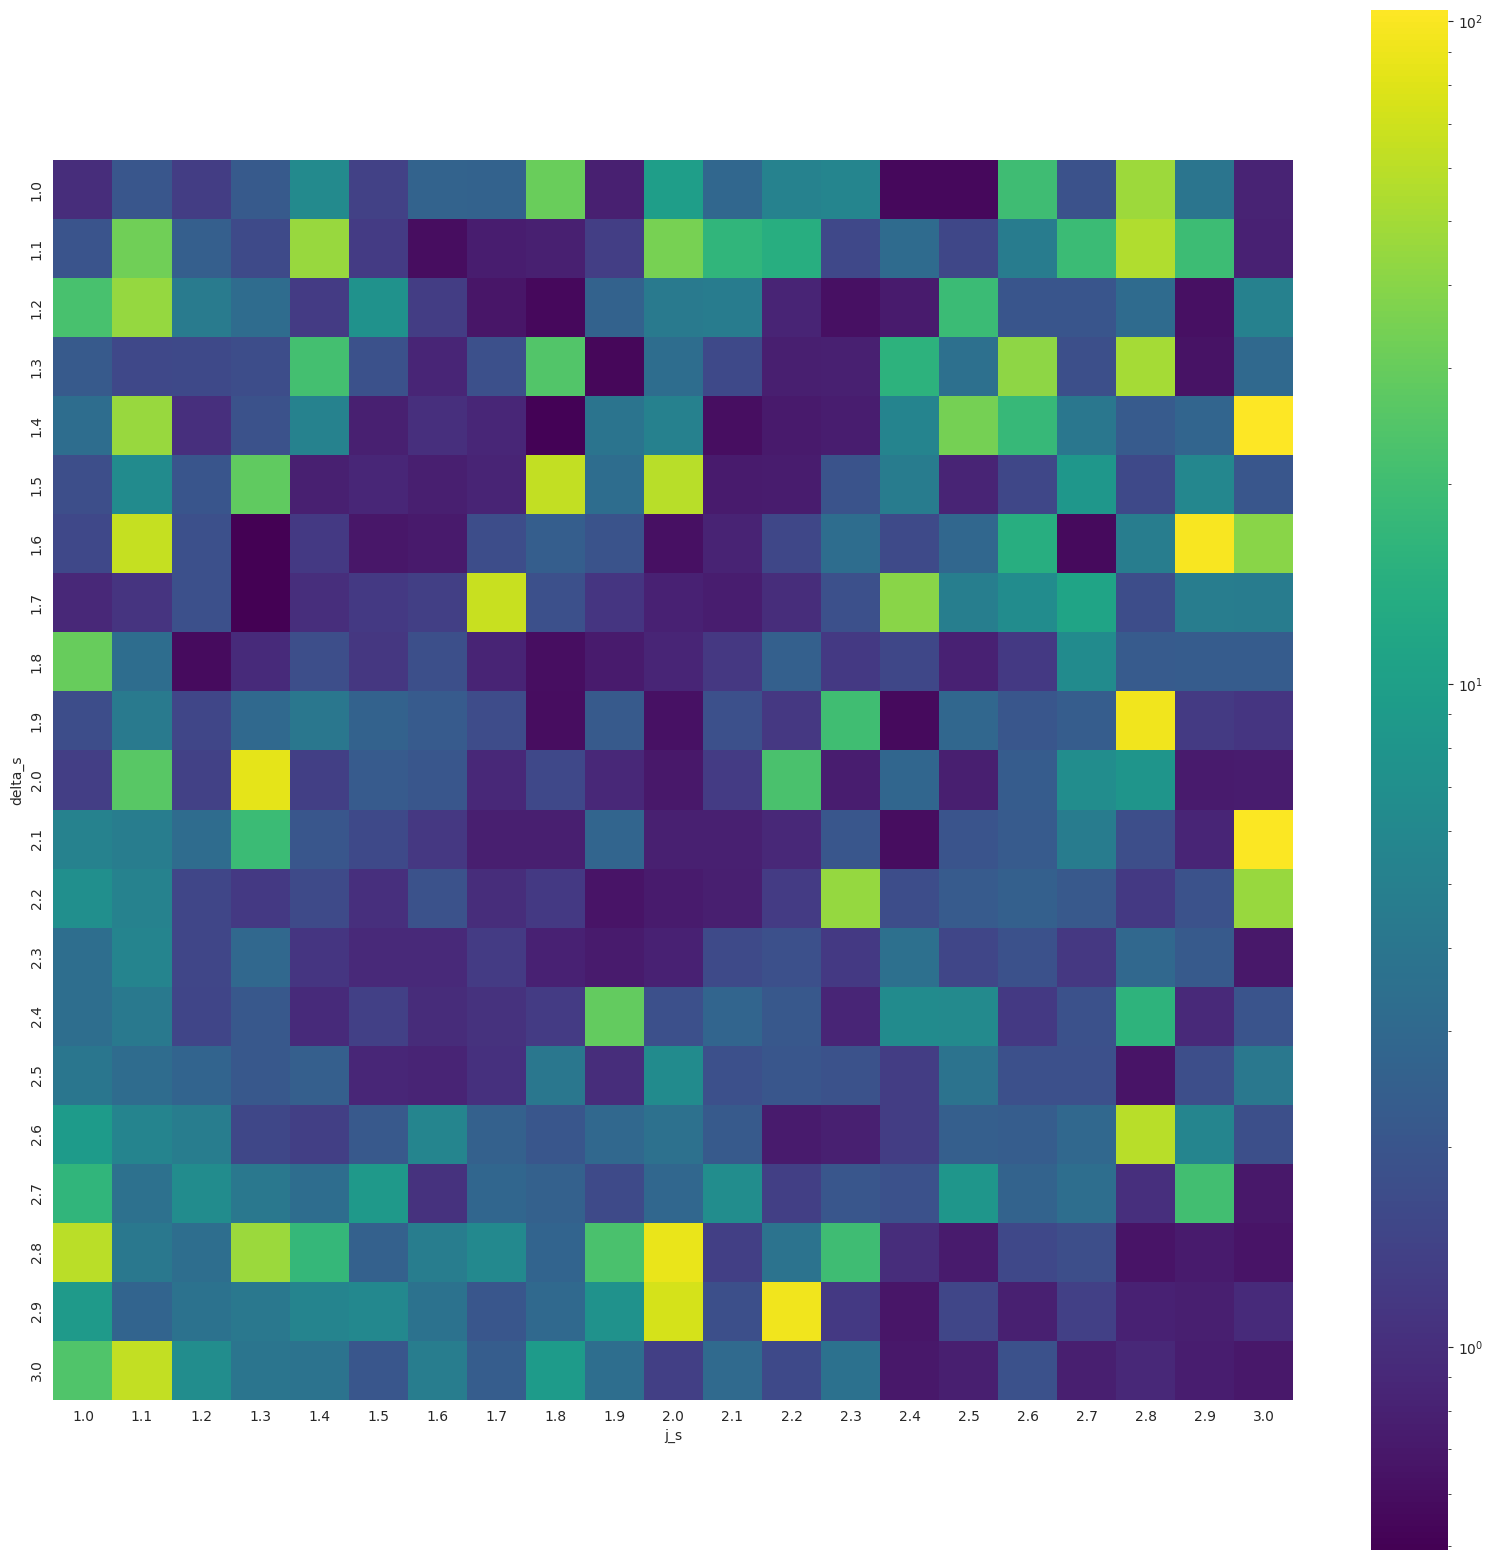

In [86]:
figure(figsize=(20, 20))
sns.heatmap(
    df.pivot(columns="j_s", index="delta_s", values="information_gain"),
    # annot=True,
    cmap='viridis',
    fmt=".2f",
    norm=LogNorm(),
    square=True,
)

<Axes: xlabel='information_gain', ylabel='Count'>

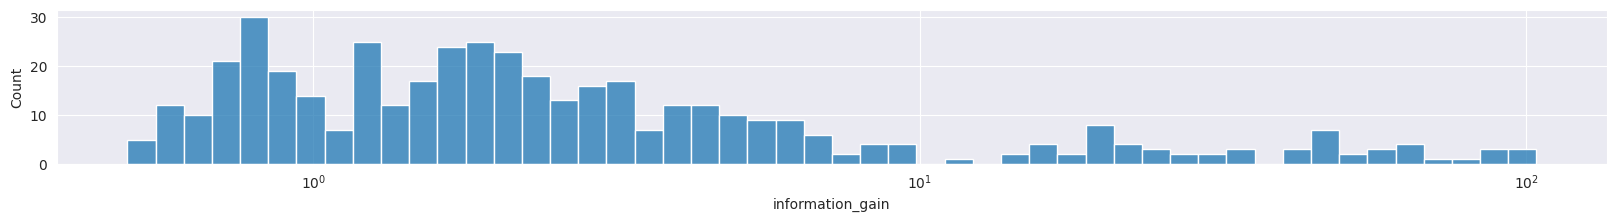

In [82]:
figure(figsize=(20, 2))
sns.histplot(
    df["information_gain"],
    bins=50,
    log_scale=True,
)

In [83]:
df[[
    "j_s",
    "delta_s",
    "time_system",
    "time_ancilla",
    "probability_difference_system",
    "probability_difference_ancilla",
    "information_gain",
]].sample(10).style.background_gradient(cmap='viridis', axis=1)

,j_s,delta_s,time_system,time_ancilla,probability_difference_system,probability_difference_ancilla,information_gain
68,1.300000,1.500000,5.639684,364.551952,0.034000,0.952512,28.015139
241,2.100000,2.000000,3.881933,7.531026,0.024824,0.030905,1.244956
358,2.700000,1.100000,3.924862,276.494498,0.019233,0.367628,19.113966
369,2.700000,2.200000,3.246020,12.456631,0.020965,0.045379,2.164502
132,1.600000,1.600000,226.997389,227.001645,0.752733,0.530308,0.704510
92,1.400000,1.800000,4.893449,13.146936,0.027870,0.048328,1.734059
9,1.000000,1.900000,8.082482,13.484732,0.030789,0.052203,1.695505
275,2.300000,1.200000,9.245340,10.090224,0.049615,0.030204,0.608772
89,1.400000,1.500000,5.467854,7.670331,0.033936,0.027065,0.797536
109,1.500000,1.400000,210.551166,218.260801,0.780461,0.616997,0.790555
